In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sqlalchemy import create_engine
import seaborn as sns

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False)
percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995
miscfeature,1406,0.963
alley,1369,0.938
fence,1179,0.808
fireplacequ,690,0.473
lotfrontage,259,0.177
garagecond,81,0.055
garagetype,81,0.055
garageyrblt,81,0.055
garagefinish,81,0.055


Checking the sales price distribution to make sure there is normality.

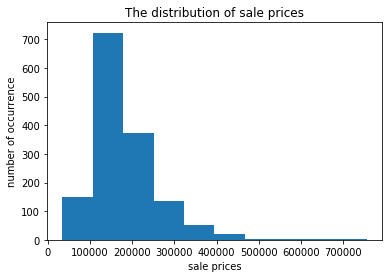

In [6]:
plt.hist(housing_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

looks like there could be some potential outliers, so I will run a boxplot to double check what I see in the histogram

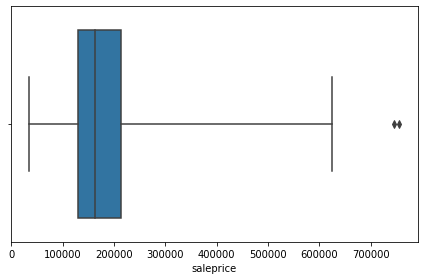

In [7]:
sns.boxplot(housing_df['saleprice'], whis = 5)
plt.tight_layout()

Checking for housing values that are outliers above 600,000

In [8]:
housing_df[(housing_df['saleprice'] > 600000)].head(50).sort_values(by = 'saleprice', ascending = False)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.000,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.000,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000
1169,1170,60,RL,118.000,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,625000
898,899,20,RL,100.000,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,611657


I think dropping these four outliers will make the model run more accurately, but will revisit this idea later

## Checking on the nulls

looks like a lot of the nulls are categorical, diving deeper some of them may be easy to replace while others may not be useful in the analysis of the data

In [9]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False)
percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995
miscfeature,1406,0.963
alley,1369,0.938
fence,1179,0.808
fireplacequ,690,0.473
lotfrontage,259,0.177
garagecond,81,0.055
garagetype,81,0.055
garageyrblt,81,0.055
garagefinish,81,0.055


### PoolQC

In [10]:
housing_df['poolqc'].unique()

array([None, 'Ex', 'Fa', 'Gd'], dtype=object)

Going to check poolqc to see if it has any relationship with the pool size

In [11]:
pool_check = housing_df[housing_df['poolarea'] > 0]

pool_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 198 to 1423
Data columns (total 81 columns):
id               7 non-null int64
mssubclass       7 non-null int64
mszoning         7 non-null object
lotfrontage      6 non-null float64
lotarea          7 non-null int64
street           7 non-null object
alley            0 non-null object
lotshape         7 non-null object
landcontour      7 non-null object
utilities        7 non-null object
lotconfig        7 non-null object
landslope        7 non-null object
neighborhood     7 non-null object
condition1       7 non-null object
condition2       7 non-null object
bldgtype         7 non-null object
housestyle       7 non-null object
overallqual      7 non-null int64
overallcond      7 non-null int64
yearbuilt        7 non-null int64
yearremodadd     7 non-null int64
roofstyle        7 non-null object
roofmatl         7 non-null object
exterior1st      7 non-null object
exterior2nd      7 non-null object
masvnrtype       7 non-nu

This validates that the nulls in pool qc are due to a lack of pool in a lot of these properties. I'll fill the nulls for poolqc with a value that states "no pool"

In [12]:
housing_df['poolqc'].fillna("no pool", inplace = True)

### Miscfeature

In [13]:
housing_df['miscfeature'].unique()

array([None, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

looks like there is too much random variety here to imputate anything, so I'll be dropping this column

In [14]:
housing_df = housing_df.drop(columns = 'miscfeature')

### Fence

In [15]:
housing_df['fence'].unique()

array([None, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

I think it's fair to assume that nulls in fence are instances where there isn't a fence.

In [16]:
housing_df['fence'].fillna("no fence", inplace = True)

### Fireplacequ

I have a feeling this will be a lot like poolqc where when there isn't a fireplace this values is NaN

In [17]:
fireplace_check = housing_df[housing_df['fireplaces'] > 0]

fireplace_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 1 to 1457
Data columns (total 80 columns):
id               770 non-null int64
mssubclass       770 non-null int64
mszoning         770 non-null object
lotfrontage      601 non-null float64
lotarea          770 non-null int64
street           770 non-null object
alley            27 non-null object
lotshape         770 non-null object
landcontour      770 non-null object
utilities        770 non-null object
lotconfig        770 non-null object
landslope        770 non-null object
neighborhood     770 non-null object
condition1       770 non-null object
condition2       770 non-null object
bldgtype         770 non-null object
housestyle       770 non-null object
overallqual      770 non-null int64
overallcond      770 non-null int64
yearbuilt        770 non-null int64
yearremodadd     770 non-null int64
roofstyle        770 non-null object
roofmatl         770 non-null object
exterior1st      770 non-null object
exterior2nd  

Again, when there is a fireplace the fireplace quality variable has a value. So in this case, I can again indicate "no fireplace" in place of nulls

In [18]:
housing_df['fireplacequ'].fillna("no fireplace", inplace = True)

### Alley

Since alley likely doesn't have a tremendous impace on house prices and I won't be using it in my model I plan on just dropping this column all together

In [19]:
housing_df = housing_df.drop(columns = 'alley')

### Remaining null values

since the remaining null values represent such a small percentage of the overall data set, I feel comfortable just dropping them.

In [20]:
housedf = housing_df.dropna()

In [21]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1459
Data columns (total 79 columns):
id               1094 non-null int64
mssubclass       1094 non-null int64
mszoning         1094 non-null object
lotfrontage      1094 non-null float64
lotarea          1094 non-null int64
street           1094 non-null object
lotshape         1094 non-null object
landcontour      1094 non-null object
utilities        1094 non-null object
lotconfig        1094 non-null object
landslope        1094 non-null object
neighborhood     1094 non-null object
condition1       1094 non-null object
condition2       1094 non-null object
bldgtype         1094 non-null object
housestyle       1094 non-null object
overallqual      1094 non-null int64
overallcond      1094 non-null int64
yearbuilt        1094 non-null int64
yearremodadd     1094 non-null int64
roofstyle        1094 non-null object
roofmatl         1094 non-null object
exterior1st      1094 non-null object
exterior2nd      1094 non

## Correlations and Feature engineering

In [22]:
non_numeric_columns = housedf.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'saletype',
       'salecondition'],
      dtype='object')
The number of non-numerical columns is 41


In [23]:
numeric_columns = housedf.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [24]:
np.abs(housedf[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice       1.000
overallqual     0.795
grlivarea       0.707
garagecars      0.652
garagearea      0.621
totalbsmtsf     0.618
firstflrsf      0.618
fullbath        0.578
totrmsabvgrd    0.561
yearbuilt       0.523
yearremodadd    0.520
garageyrblt     0.502
masvnrarea      0.485
fireplaces      0.458
bsmtfinsf1      0.379
lotfrontage     0.344
openporchsf     0.339
wooddecksf      0.330
secondflrsf     0.303
lotarea         0.302
halfbath        0.259
bsmtfullbath    0.224
bsmtunfsf       0.191
bedroomabvgr    0.168
enclosedporch   0.162
overallcond     0.139
kitchenabvgr    0.115
screenporch     0.106
poolarea        0.092
mssubclass      0.089
mosold          0.053
bsmthalfbath    0.041
bsmtfinsf2      0.037
miscval         0.036
threessnporch   0.034
yrsold          0.007
lowqualfinsf    0.004
Name: saleprice, dtype: float64

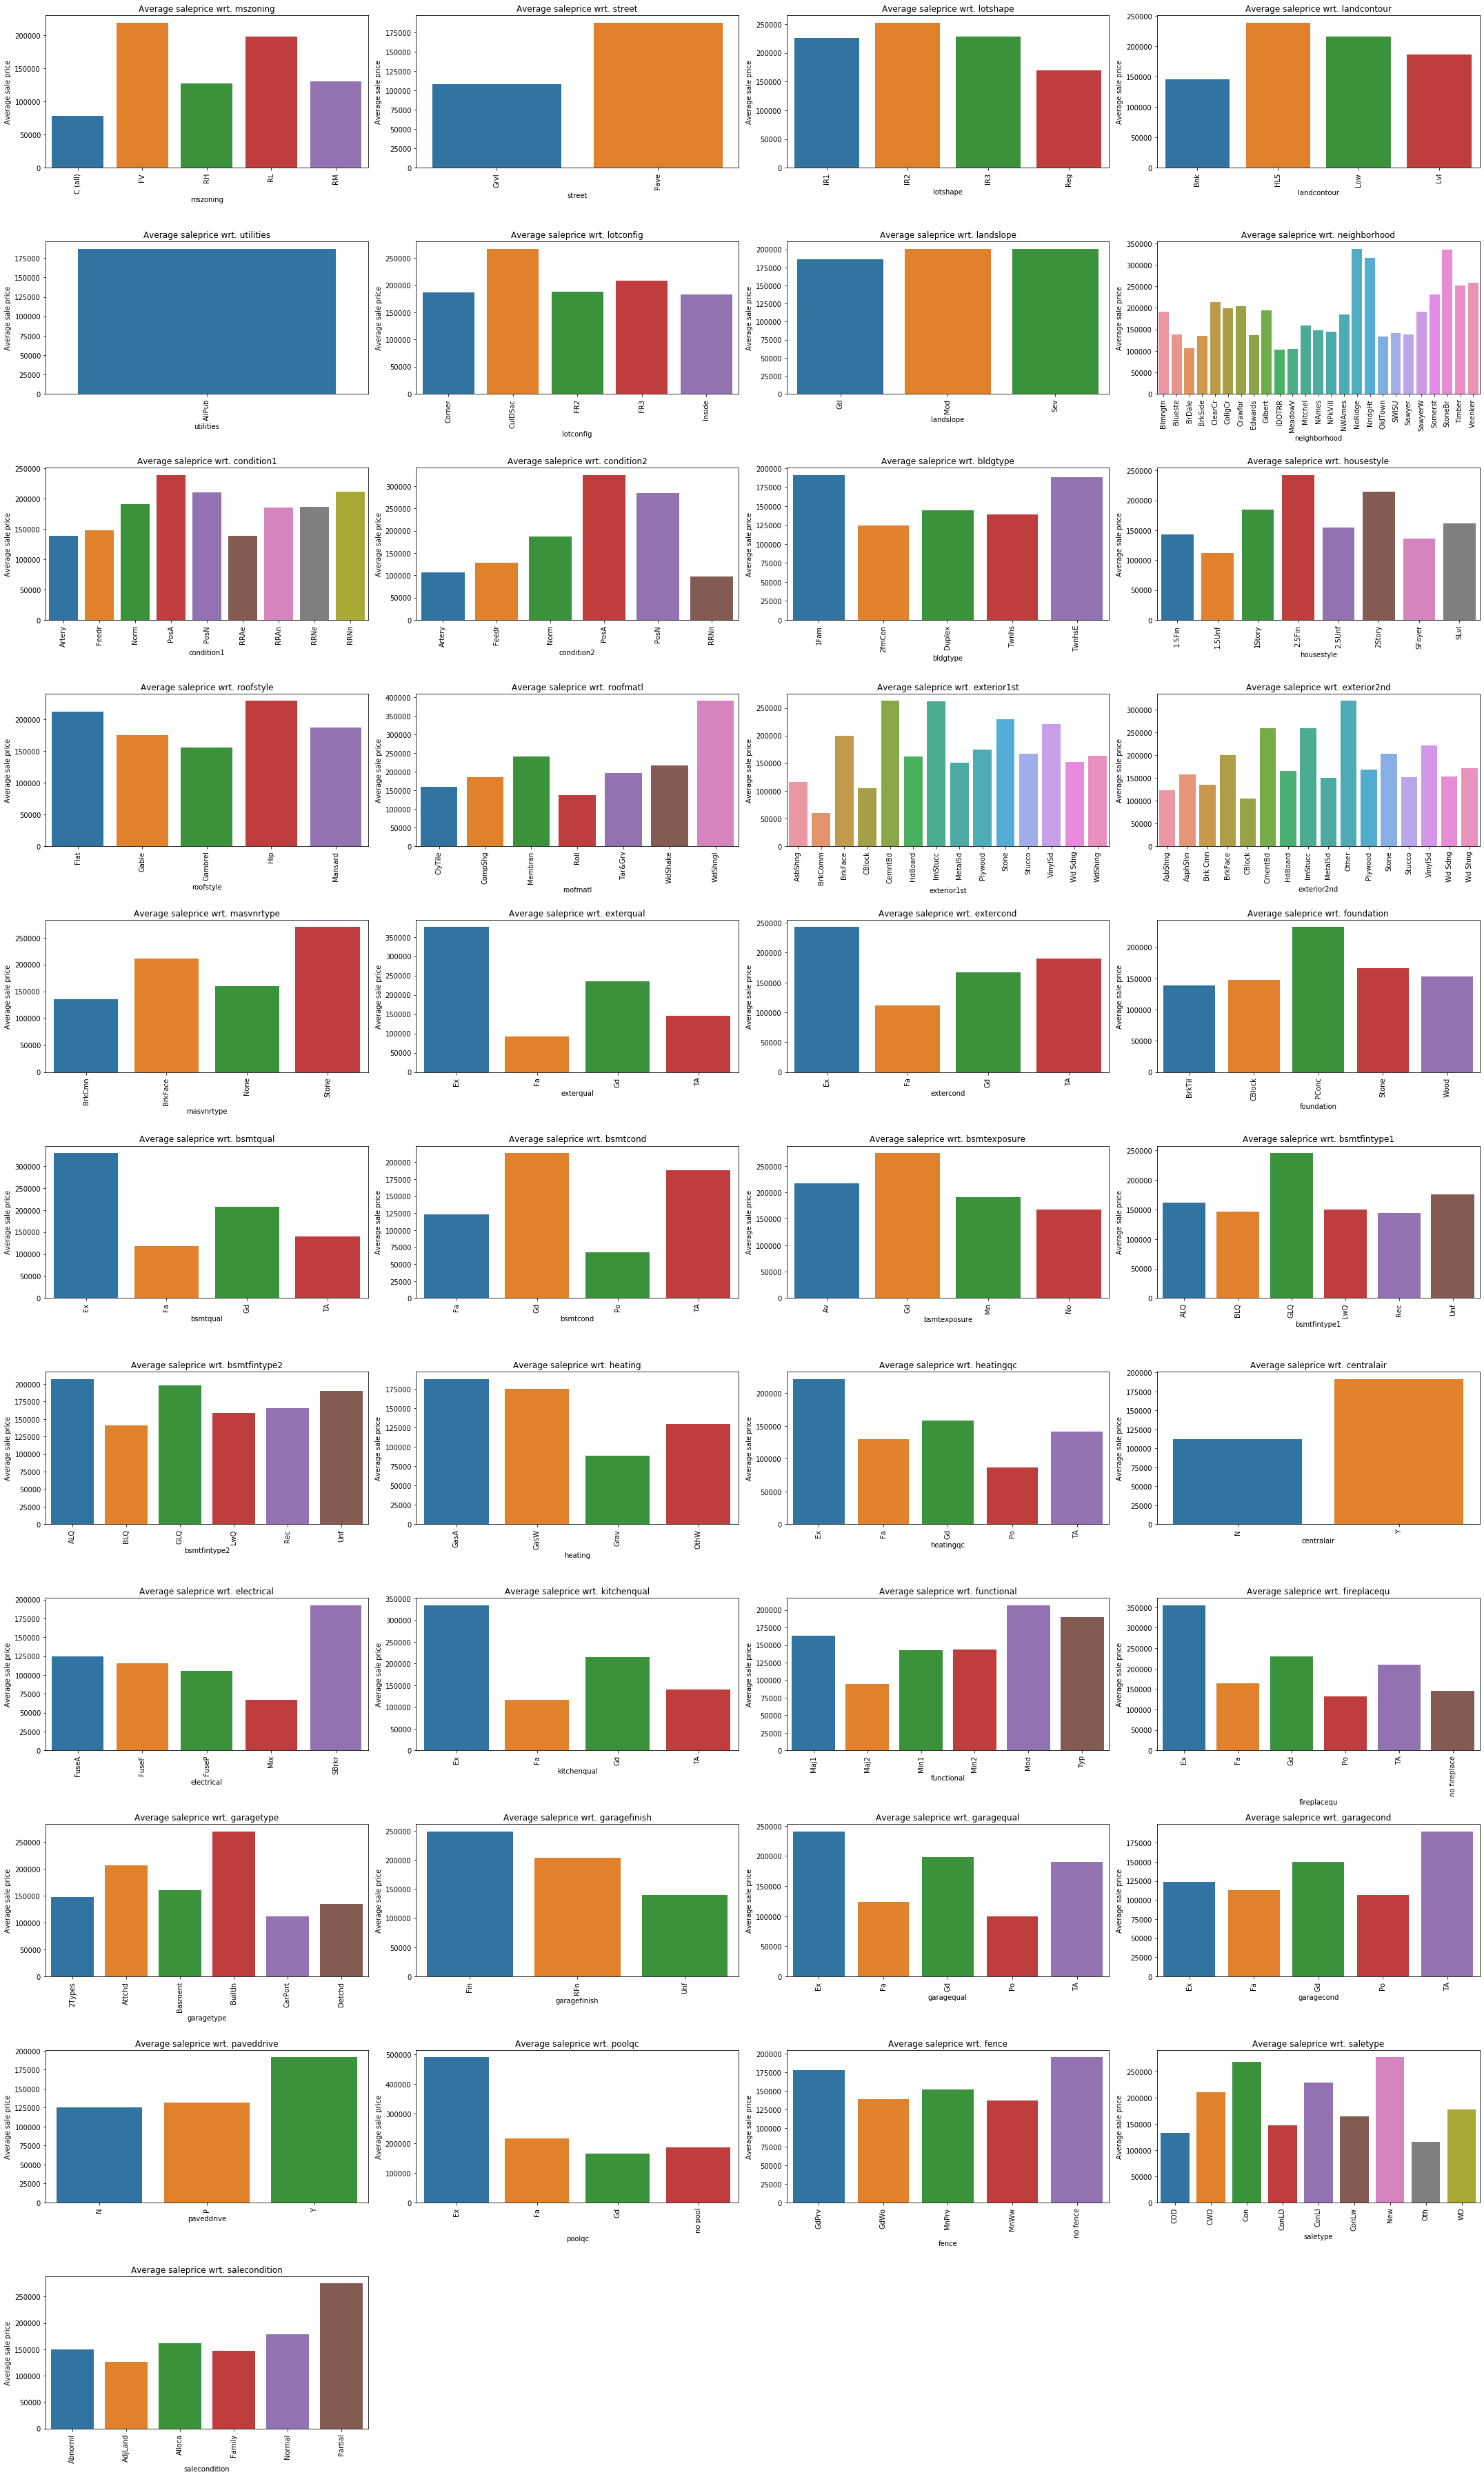

In [25]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    sns.barplot(housedf.groupby(column)["saleprice"].mean().index, housedf.groupby(column)["saleprice"].mean())
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [26]:
print(numeric_columns)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')


Looking at the correlations I've made my feature selection by what I figure to be the most impactful features on sales price. Numeric features were chosen if their correlation with target variable was over .5. I also added yrsold and mosold for the purpose of adding in additional economic data for question 6

In [27]:
chosen_features = ['mszoning', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'saletype',
       'salecondition', 'overallqual', 'grlivarea', 'garagecars', 'garagearea' ,'totalbsmtsf',
        'firstflrsf','fullbath','totrmsabvgrd','yearbuilt','yearremodadd','garageyrblt', 'saleprice', 'yrsold', 'mosold']

house_test = housedf[chosen_features]

In [28]:
house = pd.get_dummies(house_test, drop_first = True)

In [29]:
Y = house['saleprice']
X = house.drop(columns = ['saleprice'])

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 875
The number of observations in test set is 219


In [30]:
X_train = sm.add_constant(X_train)

In [31]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     50.42
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          4.58e-308
Time:                        20:31:24   Log-Likelihood:                -9986.7
No. Observations:                 875   AIC:                         2.035e+04
Df Residuals:                     689   BIC:                         2.123e+04
Df Model:                         185                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.195e+

strong multicollinearity problems or that the design matrix is singular.


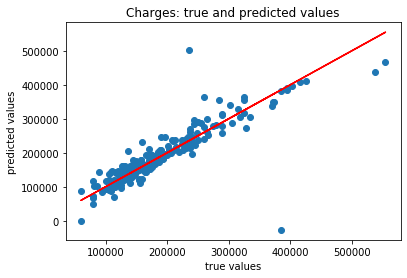

In [32]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()


In [33]:
Y = house['saleprice']
X = house.drop(columns = ['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 875
The number of observations in test set is 219
R-squared of the model in the training set is: 0.9312093110037949
-----Test set statistics-----
R-squared of the model in the test set is: 0.7442750598934824
Mean absolute error of the prediction is: 20533.190986573823
Mean squared error of the prediction is: 1701441208.6641033
Root mean squared error of the prediction is: 41248.52977578841
Mean absolute percentage error of the prediction is: 11.630901735291795


In [42]:
from sklearn import neighbors

Y = house['saleprice']
X = house.drop(columns = ['saleprice'])

knn_t = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_t.fit(X, Y)

score = cross_val_score(knn_t, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.72 (+/- 0.09)


Comparing KNN and Linear Regression, Linear regression had a higher accuracy but a penchant to overfit

